In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
import datetime, os

%load_ext tensorboard

In [2]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
print("train images", train_images.shape)
print("train labels", train_labels.shape)
print("test images", test_images.shape)
print("test labels", test_labels.shape)

train images (60000, 28, 28)
train labels (60000,)
test images (10000, 28, 28)
test labels (10000,)


## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

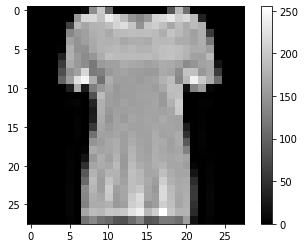

In [6]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [7]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

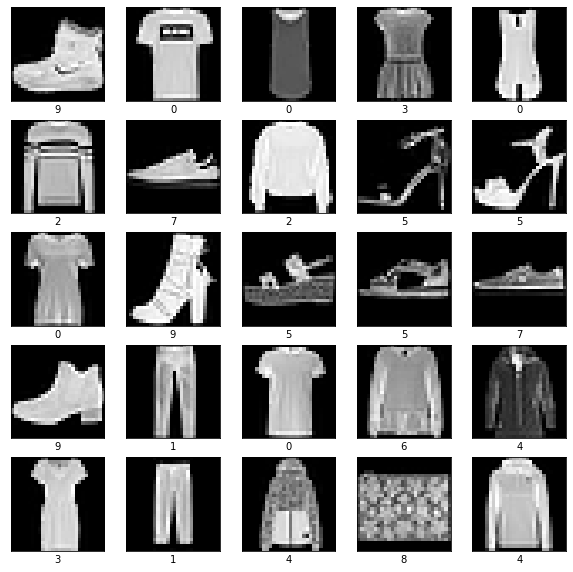

In [8]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

### Diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.

In [9]:
label_dict = {0:"T-shirt/top", 
					1: "Trouser", 
					2: "Pullover", 
					3: "Dress", 
					4: "Coat", 
					5: "Sandal", 
					6: "Shirt", 
					7: "Sneaker", 
					8: "Bag", 
					9: "Ankle boot"}
label_dict

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

### Convertir las categorías de los  data frames Train y Test en numéricos con OHE

In [10]:
## train labels
# define automáticamente las categorías
ohe_train = OneHotEncoder(categories='auto') 
# integer encode
ohe_train.fit(train_labels.reshape(-1, 1))
ohelabels_train = ohe_train.transform(train_labels.reshape(-1,1)).toarray()

## test labels
# define automáticamente las categorías
ohe_test = OneHotEncoder(categories='auto')
# integer encode
ohe_test.fit(test_labels.reshape(-1, 1))
ohelabels_test = ohe_test.transform(test_labels.reshape(-1,1)).toarray()

In [11]:
def procesa_imagenes(images,p_proceso):

    # Vector de imágenes
    tr = images.reshape(-1, 28 * 28)
    if p_proceso == 'N': # Si el tipo de proceso es Normalizar
        tr = normalize(tr, norm = "max", axis = 1)
    elif p_proceso == 'S': #Si el tipo de proceso es Scaled
        tr = scale(tr)

    tr = np.insert(tr, 0, np.ones(len(tr)), axis=1).astype(np.float32)
    print(tr.shape)
    return tr

In [12]:
# Datos crudos de imágenes
x_train = procesa_imagenes(train_images,'R')
x_test = procesa_imagenes(test_images,'R')

(60000, 785)
(10000, 785)


In [13]:
# Datos normalizados
x_train_n = procesa_imagenes(train_images,'N')
x_test_n = procesa_imagenes(test_images,'N')

(60000, 785)
(10000, 785)


In [14]:
# Datos Scaled
x_train_s = procesa_imagenes(train_images,'N')
x_test_s = procesa_imagenes(test_images,'N')

(60000, 785)
(10000, 785)


### Regresión Logística

In [15]:
class LRSoftmax:
    def __init__(self, x, labels):
        #vector de weights con n features
        self.w = tf.get_variable("weights", dtype = tf.float32, shape = [x_train.shape[1], labels.shape[1]], initializer = tf.zeros_initializer())
        
    # Activación por etiqueta 
    def problog(self, x):
        return tf.matmul(x, self.w)

    # Funcion para generar prediccion de modelo
    def predictiModel(self, x):
        return tf.nn.softmax(self.problog(x))
    
    #Obtiene la precisión
    def getAccuracy(self, predictiModel, labels):
        precision = tf.equal(tf.argmax(predictiModel,1), tf.argmax(labels,1))
        precision = tf.dtypes.cast(precision, tf.int32)
        precision = tf.divide(tf.reduce_sum(precision), tf.shape(labels)[0])
        return precision
            
    def actualiza(self, x_train, labels_train, x_test, labels_test, learningrate):
        
        with tf.name_scope("Error"):
            train_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels_train, logits = self.problog(x_train)))
            train_error_summary = tf.summary.scalar("Train", train_error)
            test_error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels_test, logits = self.problog(x_test)))
            test_error_summary = tf.summary.scalar("Test", test_error)
        
        # Prueba del funcionamiento del modelo
        with tf.name_scope("Precision"):
            # Evalúa el modelo de entrenamiento
            train_accuracy = self.getAccuracy(self.predictiModel(x_train), labels_train)
            train_accuracy_summary = tf.summary.scalar("Train", train_accuracy)
            # Evalúa el modelo de prueba
            test_accuracy = self.getAccuracy(self.predictiModel(x_test), labels_test)
            test_accuracy_summary = tf.summary.scalar("Test", test_accuracy)
            
        # Actualiza parámetros
        gradient = tf.gradients(train_error, [self.w])
        updated_w = tf.assign(self.w, self.w - learningrate * gradient[0])
        
        return updated_w, train_error, test_error, train_accuracy, test_accuracy, train_error_summary, test_error_summary, train_accuracy_summary, test_accuracy_summary

In [16]:
def f_entrena(lr, epochs, bs, visual, labels_train, labels_test, x_train, x_test):
    # Cálculo de los pasos del minibatch
    batch_steps = int((len(ohelabels_train) / bs) * epochs) + 1 
    print("Batch_Steps: ", batch_steps)
    
    # String para definicion de experimento
    string = './fashiongraphs/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"_lr="+str(lr)+ "_epochs="+str(epochs)

    g = tf.Graph()
    with g.as_default():
        # Inicialización de objeto de clase LogisticRegressionSoftmax
        modelo = LRSoftmax(x_train, ohelabels_train)
        # Definicion de placeholders para input de data a grafo
        with tf.name_scope("Tensor_train"):
            tensor_x_train = tf.placeholder(tf.float32, [None,x_train.shape[1]], "tensor_x_train")
            tensor_labels_train = tf.placeholder(tf.float32, [None,labels_train.shape[1]], "tensor_labels_train")
        with tf.name_scope("Tensor_test"):
            tensor_x_test = tf.placeholder(tf.float32, [x_test.shape[0], x_test.shape[1]], "tensor_x_test")
            tensor_labels_test = tf.placeholder(tf.float32, [labels_test.shape[0], labels_test.shape[1]], "tensor_labels_test")
        
        # Utilizacion de método update para hacer el entrenamiento
        update_parameters = modelo.actualiza(tensor_x_train, tensor_labels_train, tensor_x_test, tensor_labels_test, lr)
    
        # Writer para utilizacion de tensorboard
        writer = tf.summary.FileWriter(string, g)
        
        with tf.train.MonitoredSession() as session:
            
            for i in range(batch_steps):
                # Mini batch gradient descent with batch size 32
                offset = (i * bs) % (labels_train.shape[0] - bs)
                batch_data = x_train[offset:(offset + bs),]
                batch_labels = labels_train[offset:(offset + bs),]
                feed_dict = {tensor_x_train:batch_data, tensor_labels_train:batch_labels,tensor_x_test:x_test, tensor_labels_test:labels_test}
                
                # Entrenamiento
                training = session.run(update_parameters, feed_dict = feed_dict)
                
                if (i)%visual == 0:
                    # Agregar datos para tensorboard
                    writer.add_summary(training[5], i)
                    writer.add_summary(training[6], i)
                    writer.add_summary(training[7], i)
                    writer.add_summary(training[8], i)
                    print("Epoch:", int(i//(len(ohelabels_train) / bs)+1))
                    print("Batch Step:", i, "train error:", training[1], "train accuracy:", training[3], "test error:", training[2], "test accuracy:", training[4])

                    # Pesos 
                    weights = session.run(modelo.w, feed_dict = feed_dict)
            
            return weights

            writer.close()

## Entrenamientos

In [17]:
# f_entrena(lr, epochs, bs, visual, labels_train, labels_test, x_train, x_test):
w_crudos = f_entrena(0.01, 10, 32, 150, ohelabels_train, ohelabels_test, x_train, x_test)

Batch_Steps:  18751
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch: 1
Batch Step: 0 train error: 2.3025851 train accuracy: 0.1875 test error: 2.302591 test accuracy: 0.1
Epoch: 1
Batch Step: 150 train error: 1353.7875 train accuracy: 0.75 test error: 1125.0408 test accuracy: 0.7744000000000001
Epoch: 1
Batch Step: 300 train error: 4230.0 train accuracy: 0.5 test error: 5607.8906 test accuracy: 0.5803
Epoch: 1
Batch Step: 450 train error: 5415.6084 train accuracy: 0.5625 test error: 3054.861 test accuracy: 0.7062
Epoch: 1
Batch Step: 600 train error: 1032.7993 train accuracy: 0.84375 test error: 2265.6116 test accuracy: 0.7230000000000001
Epoch: 1
Batch Step: 750 train error: 2208.8066 train accuracy: 0.8125 test error: 1

Epoch: 6
Batch Step: 9600 train error: 1573.7434 train accuracy: 0.75 test error: 1345.027 test accuracy: 0.7763
Epoch: 6
Batch Step: 9750 train error: 1268.7577 train accuracy: 0.8125 test error: 2081.5059 test accuracy: 0.7831
Epoch: 6
Batch Step: 9900 train error: 1261.2194 train accuracy: 0.84375 test error: 2014.838 test accuracy: 0.7718
Epoch: 6
Batch Step: 10050 train error: 1449.1472 train accuracy: 0.71875 test error: 1991.8884 test accuracy: 0.7695000000000001
Epoch: 6
Batch Step: 10200 train error: 183.7251 train accuracy: 0.9375 test error: 1152.4738 test accuracy: 0.7952
Epoch: 6
Batch Step: 10350 train error: 1201.331 train accuracy: 0.75 test error: 1749.0952 test accuracy: 0.8059000000000001
Epoch: 6
Batch Step: 10500 train error: 879.0532 train accuracy: 0.78125 test error: 1092.7563 test accuracy: 0.8042
Epoch: 6
Batch Step: 10650 train error: 1214.0334 train accuracy: 0.8125 test error: 896.3294 test accuracy: 0.8297
Epoch: 6
Batch Step: 10800 train error: 1448.1423 

In [18]:
w_normal = f_entrena(0.01, 10, 32, 150, ohelabels_train, ohelabels_test, x_train_n, x_test_n)

Batch_Steps:  18751
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch: 1
Batch Step: 0 train error: 2.3025851 train accuracy: 0.1875 test error: 2.2764719 test accuracy: 0.1143
Epoch: 1
Batch Step: 150 train error: 1.1332021 train accuracy: 0.6875 test error: 1.1686243 test accuracy: 0.6553
Epoch: 1
Batch Step: 300 train error: 1.0852971 train accuracy: 0.65625 test error: 0.96187246 test accuracy: 0.6873
Epoch: 1
Batch Step: 450 train error: 0.93049073 train accuracy: 0.625 test error: 0.871316 test accuracy: 0.7213
Epoch: 1
Batch Step: 600 train error: 0.69067657 train accuracy: 0.75 test error: 0.81087893 test accuracy: 0.7397
Epoch: 1
Batch Step: 750 train error: 0.9024314 train accuracy: 0.6875 test error: 0.78525877 test accuracy: 0.7353000000000001
Epoch: 1
Batch Step: 900 train error: 0.91368186 train accuracy: 0.6875 test error: 0.74450284 test accuracy: 0.7585000000000001
Epoch: 1
Batch Step: 1050 tra

Epoch: 6
Batch Step: 10050 train error: 0.5159161 train accuracy: 0.8125 test error: 0.51138175 test accuracy: 0.8265
Epoch: 6
Batch Step: 10200 train error: 0.35080814 train accuracy: 0.875 test error: 0.51307774 test accuracy: 0.8244
Epoch: 6
Batch Step: 10350 train error: 0.3278249 train accuracy: 0.90625 test error: 0.51193035 test accuracy: 0.8244
Epoch: 6
Batch Step: 10500 train error: 0.55299866 train accuracy: 0.78125 test error: 0.51271105 test accuracy: 0.8250000000000001
Epoch: 6
Batch Step: 10650 train error: 0.47101343 train accuracy: 0.8125 test error: 0.5114391 test accuracy: 0.8270000000000001
Epoch: 6
Batch Step: 10800 train error: 0.35690835 train accuracy: 0.90625 test error: 0.5108224 test accuracy: 0.8277
Epoch: 6
Batch Step: 10950 train error: 0.5394646 train accuracy: 0.8125 test error: 0.50796807 test accuracy: 0.8280000000000001
Epoch: 6
Batch Step: 11100 train error: 0.4273605 train accuracy: 0.8125 test error: 0.5135039 test accuracy: 0.8228000000000001
Epoch

In [19]:
w_scaled = f_entrena(0.01, 10, 32, 150, ohelabels_train, ohelabels_test, x_train_s, x_test_s)

Batch_Steps:  18751
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch: 1
Batch Step: 0 train error: 2.3025851 train accuracy: 0.1875 test error: 2.302591 test accuracy: 0.1
Epoch: 1
Batch Step: 150 train error: 1.1332021 train accuracy: 0.6875 test error: 1.1685843 test accuracy: 0.6553
Epoch: 1
Batch Step: 300 train error: 1.0852971 train accuracy: 0.65625 test error: 0.9618338 test accuracy: 0.6873
Epoch: 1
Batch Step: 450 train error: 0.93049073 train accuracy: 0.625 test error: 0.8696086 test accuracy: 0.7199
Epoch: 1
Batch Step: 600 train error: 0.69067657 train accuracy: 0.75 test error: 0.81146836 test accuracy: 0.7414000000000001
Epoch: 1
Batch Step: 750 train error: 0.9024314 train accuracy: 0.6875 test error: 0.7790912 test accuracy: 0.7415
Epoch: 1
Batch Step: 900 train error: 0.91368186 train accuracy: 0.6875 test error: 0.7445059 test accuracy: 0.7585000000000001
Epoch: 1
Batch Step: 1050 train err

Epoch: 6
Batch Step: 10050 train error: 0.5159161 train accuracy: 0.8125 test error: 0.51138175 test accuracy: 0.8265
Epoch: 6
Batch Step: 10200 train error: 0.35080814 train accuracy: 0.875 test error: 0.5131453 test accuracy: 0.8242
Epoch: 6
Batch Step: 10350 train error: 0.3278249 train accuracy: 0.90625 test error: 0.5119607 test accuracy: 0.8245
Epoch: 6
Batch Step: 10500 train error: 0.55299866 train accuracy: 0.78125 test error: 0.51266927 test accuracy: 0.8250000000000001
Epoch: 6
Batch Step: 10650 train error: 0.47101343 train accuracy: 0.8125 test error: 0.511575 test accuracy: 0.8278000000000001
Epoch: 6
Batch Step: 10800 train error: 0.35690835 train accuracy: 0.90625 test error: 0.5095689 test accuracy: 0.8270000000000001
Epoch: 6
Batch Step: 10950 train error: 0.5394646 train accuracy: 0.8125 test error: 0.5079765 test accuracy: 0.8279000000000001
Epoch: 6
Batch Step: 11100 train error: 0.4273605 train accuracy: 0.8125 test error: 0.51415896 test accuracy: 0.8228000000000

In [20]:
w_normal = f_entrena(0.01, 5, 32, 150, ohelabels_train, ohelabels_test, x_train_n, x_test_n)

Batch_Steps:  9376
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch: 1
Batch Step: 0 train error: 2.3025851 train accuracy: 0.1875 test error: 2.2764268 test accuracy: 0.1136
Epoch: 1
Batch Step: 150 train error: 1.1332021 train accuracy: 0.6875 test error: 1.1686329 test accuracy: 0.6551
Epoch: 1
Batch Step: 300 train error: 1.0852971 train accuracy: 0.65625 test error: 0.9618674 test accuracy: 0.6875
Epoch: 1
Batch Step: 450 train error: 0.93049073 train accuracy: 0.625 test error: 0.87130654 test accuracy: 0.7211000000000001
Epoch: 1
Batch Step: 600 train error: 0.69067657 train accuracy: 0.75 test error: 0.8108696 test accuracy: 0.7394000000000001
Epoch: 1
Batch Step: 750 train error: 0.9024314 train accuracy: 0.6875 test error: 0.7851324 test accuracy: 0.7348
Epoch: 1
Batch Step: 900 train error: 0.91368186 train accuracy: 0.6875 test error: 0.744505 test accuracy: 0.7585000000000001
Epoch: 1
Batch Step: 

In [21]:
w_scaled = f_entrena(0.01, 5, 32, 150, ohelabels_train, ohelabels_test, x_train_s, x_test_s)

Batch_Steps:  9376
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch: 1
Batch Step: 0 train error: 2.3025851 train accuracy: 0.1875 test error: 2.2768357 test accuracy: 0.1159
Epoch: 1
Batch Step: 150 train error: 1.1332021 train accuracy: 0.6875 test error: 1.1685802 test accuracy: 0.6557000000000001
Epoch: 1
Batch Step: 300 train error: 1.0852971 train accuracy: 0.65625 test error: 0.966726 test accuracy: 0.6846
Epoch: 1
Batch Step: 450 train error: 0.93049073 train accuracy: 0.625 test error: 0.8713108 test accuracy: 0.7210000000000001
Epoch: 1
Batch Step: 600 train error: 0.69067657 train accuracy: 0.75 test error: 0.81174904 test accuracy: 0.742
Epoch: 1
Batch Step: 750 train error: 0.9024314 train accuracy: 0.6875 test error: 0.78522384 test accuracy: 0.735
Epoch: 1
Batch Step: 900 train error: 0.91368186 train accuracy: 0.6875 test error: 0.74453145 test accuracy: 0.7584000000000001
Epoch: 1
Batch Step: 

In [22]:
w_normal = f_entrena(0.001, 5, 32, 150, ohelabels_train, ohelabels_test, x_train_n, x_test_n)

Batch_Steps:  9376
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch: 1
Batch Step: 0 train error: 2.3025851 train accuracy: 0.1875 test error: 2.2998407 test accuracy: 0.1182
Epoch: 1
Batch Step: 150 train error: 2.0153086 train accuracy: 0.5 test error: 2.004593 test accuracy: 0.5652
Epoch: 1
Batch Step: 300 train error: 1.8180267 train accuracy: 0.625 test error: 1.8047582 test accuracy: 0.6433
Epoch: 1
Batch Step: 450 train error: 1.7087456 train accuracy: 0.46875 test error: 1.654699 test accuracy: 0.6458
Epoch: 1
Batch Step: 600 train error: 1.4528124 train accuracy: 0.71875 test error: 1.5365303 test accuracy: 0.6528
Epoch: 1
Batch Step: 750 train error: 1.4819818 train accuracy: 0.53125 test error: 1.44352 test accuracy: 0.6515000000000001
Epoch: 1
Batch Step: 900 train error: 1.3976748 train accuracy: 0.625 test error: 1.3677043 test accuracy: 0.6582
Epoch: 1
Batch Step: 1050 train error: 1.1576889 tra

In [23]:
w_scaled = f_entrena(0.001, 5, 32, 150, ohelabels_train, ohelabels_test, x_train_s, x_test_s)

Batch_Steps:  9376
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch: 1
Batch Step: 0 train error: 2.3025851 train accuracy: 0.1875 test error: 2.2997859 test accuracy: 0.11460000000000001
Epoch: 1
Batch Step: 150 train error: 2.0153086 train accuracy: 0.5 test error: 2.0046012 test accuracy: 0.5647
Epoch: 1
Batch Step: 300 train error: 1.8180267 train accuracy: 0.625 test error: 1.8047558 test accuracy: 0.6433
Epoch: 1
Batch Step: 450 train error: 1.7087456 train accuracy: 0.46875 test error: 1.6547023 test accuracy: 0.6458
Epoch: 1
Batch Step: 600 train error: 1.4528124 train accuracy: 0.71875 test error: 1.5365216 test accuracy: 0.6527000000000001
Epoch: 1
Batch Step: 750 train error: 1.4819818 train accuracy: 0.53125 test error: 1.4435159 test accuracy: 0.6515000000000001
Epoch: 1
Batch Step: 900 train error: 1.3976748 train accuracy: 0.625 test error: 1.3677067 test accuracy: 0.6582
Epoch: 1
Batch Step: 10

## Grafo con TensorBoard

In [27]:
#logs_base_dir = "./fashiongraphs"
#os.makedirs(logs_base_dir, exist_ok=True)
#%load_ext tensorboard

In [26]:
#%tensorboard --logdir {logs_base_dir} --host=127.0.0.1 --port 6006 #./covidgr --port 6006
#%tensorboard dev upload --logdir \ './fashiongraphs' -h

## Grafo

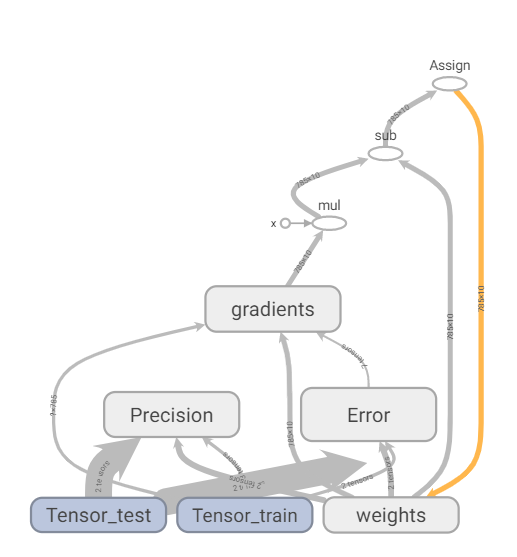

## Escalares

### ***Precisión (accuracy)***

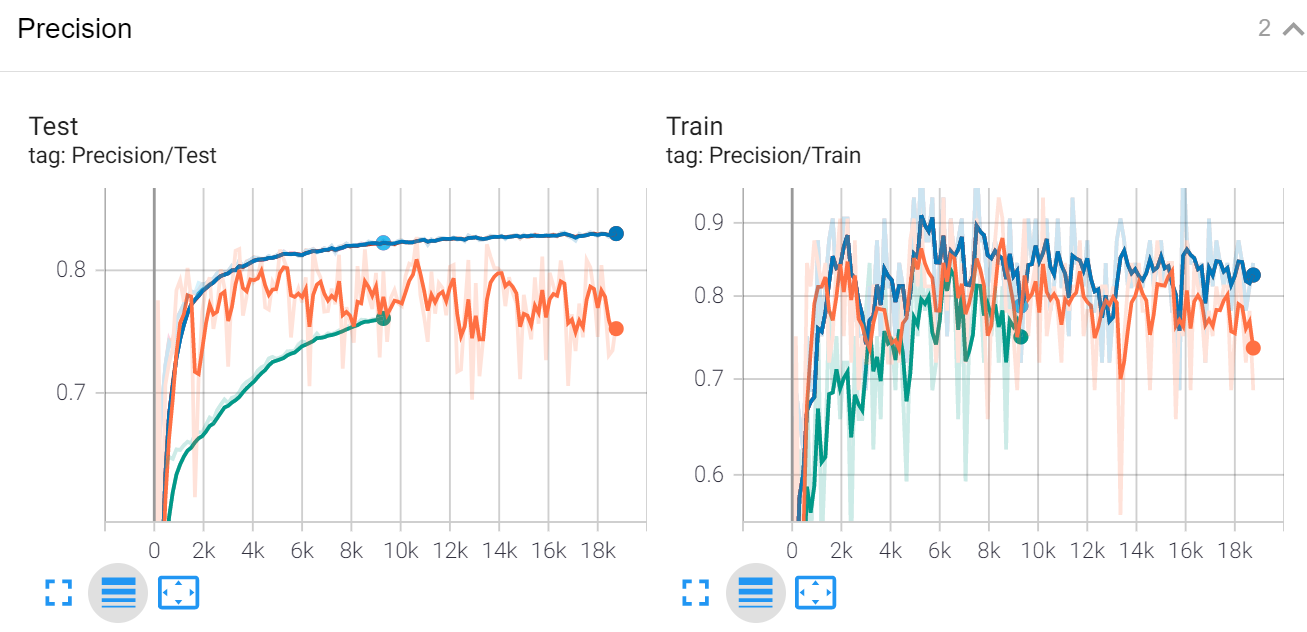

### ***Error***

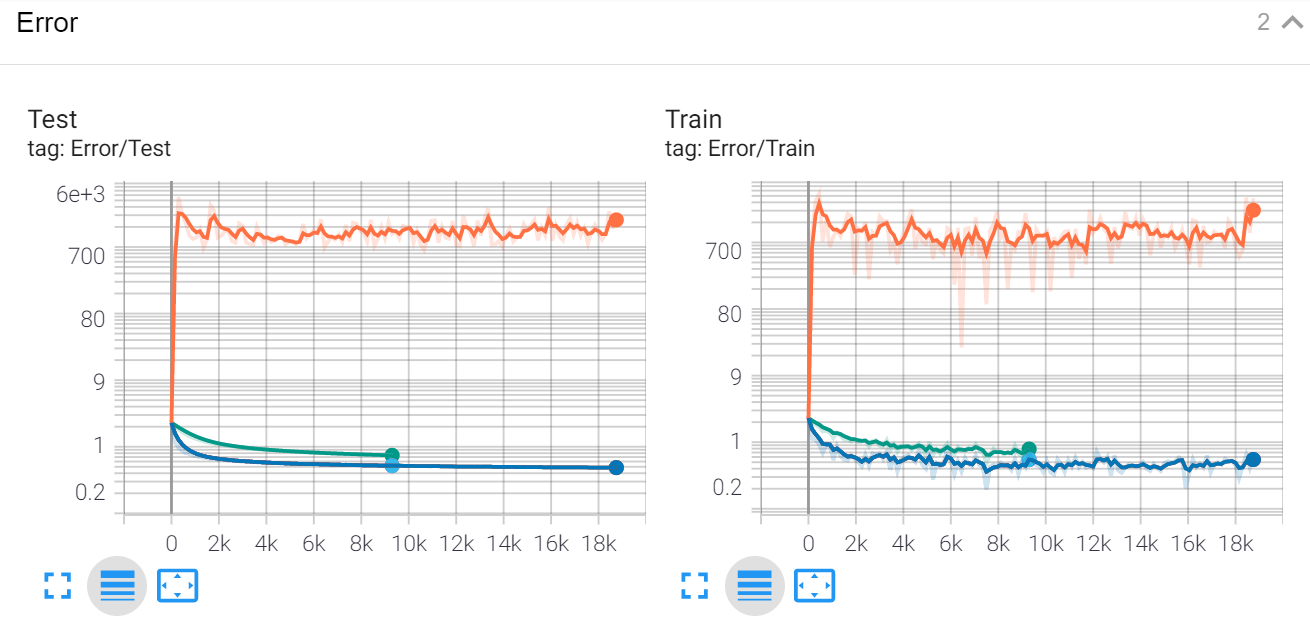